In [13]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [268]:
%%R
mydata <- read.table("cpu-trend-03.txt", sep = ';')
str(mydata)
#newdata <- subset(mydata, V2 == "vm2953")
#newdata

'data.frame':	23124 obs. of  3 variables:
 $ V1: Factor w/ 21487 levels "2018-03-06 14:02:10",..: 1 2 43 3 4 46 5 6 48 7 ...
 $ V2: Factor w/ 3 levels "vmy2954","vmy2955",..: 3 2 1 3 2 1 3 2 1 3 ...
 $ V3: num  8.99 24.46 24.5 6.19 17.99 ...


In [269]:
%%R
library(dplyr)
mydata$time <-as.POSIXct(mydata[,1], format="%Y-%m-%d %H:%M:%S")
mydata$vm <- as.character(mydata[,2])
myvar <- c("time","vm","V3")
newdata <-mydata[myvar]
data <- (newdata %>% filter(vm == "vmy2954"))
str(data)

'data.frame':	7918 obs. of  3 variables:
 $ time: POSIXct, format: "2018-03-06 14:05:59" "2018-03-06 14:06:10" ...
 $ vm  : chr  "vmy2954" "vmy2954" "vmy2954" "vmy2954" ...
 $ V3  : num  24.5 26.1 21.9 19.4 25.1 ...


In [270]:

%%R
require(zoo)
data.zoo <- with(data, zoo(V3, order.by = time))

In [271]:
%%R
require(xts)
tsdata <- as.xts(data.zoo)


In [284]:
%%R
require(xts)
data.xts <- xts(data$V3, data$time)
means.xts <- period.apply(data.xts, endpoints(data.xts, "mins", k=1), mean)
means.rounded <- align.time(means.xts, 60)

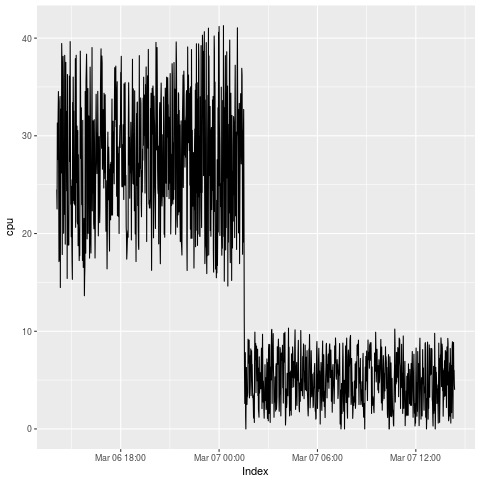

In [286]:
%%R
cpu <-means.rounded
cpu
autoplot(cpu)

In [274]:
%%R
#adf.test(cpu)
Box.test(cpu, lag = 50, type ="Ljung-Box")


	Box-Ljung test

data:  cpu
X-squared = NA, df = 50, p-value = NA




 ARIMA(0,1,0)                    : 128.6834
 ARIMA(0,1,0) with drift         : 129.1061
 ARIMA(0,1,1)                    : 126.4855
 ARIMA(0,1,1) with drift         : 127.9774
 ARIMA(0,1,2)                    : 128.8972
 ARIMA(0,1,2) with drift         : 130.3772
 ARIMA(0,1,3)                    : 131.5273
 ARIMA(0,1,3) with drift         : 133.5554
 ARIMA(0,1,4)                    : 134.7011
 ARIMA(0,1,4) with drift         : 137.143
 ARIMA(0,1,5)                    : 138.0581
 ARIMA(0,1,5) with drift         : Inf
 ARIMA(1,1,0)                    : 127.7137
 ARIMA(1,1,0) with drift         : 129.3101
 ARIMA(1,1,1)                    : 128.8345
 ARIMA(1,1,1) with drift         : 130.3424
 ARIMA(1,1,2)                    : 131.7201
 ARIMA(1,1,2) with drift         : 133.5696
 ARIMA(1,1,3)                    : 134.7363
 ARIMA(1,1,3) with drift         : Inf
 ARIMA(1,1,4)                    : 138.1541
 ARIMA(1,1,4) with drift         : Inf
 ARIMA(2,1,0)                    : 129.9778
 AR

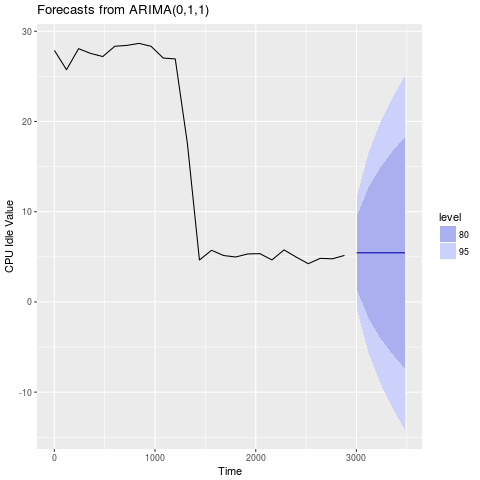

In [275]:
%%R
library(forecast)
#fit <- auto.arima(cpu,  allowmean = TRUE, stepwise=FALSE, approximation=FALSE, trace = TRUE)
fit1 <- auto.arima(cpu,stepwise = FALSE, approximation = FALSE,trace = TRUE)
fit2 <-arima(cpu, order =c(1,1,2),include.mean = TRUE)
fit3 <- arfima(cpu,drange = c(0, 0.8),estim = c("mle", "ls"))
fcst <- forecast(fit1,5)
ggAcf(residuals(fit3))
#ggPacf(cpu) + ggtitle ("Test for data being white noise")
autoplot(fcst) + xlab("Time") + ylab("CPU Idle Value")

In [276]:
%%R
accuracy(fit1)

                     ME    RMSE      MAE       MPE     MAPE      MASE
Training set -0.5836628 2.98535 1.814902 -7.117684 23.17592 0.1171481
                   ACF1
Training set -0.1024057


/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: `geom_smooth()` using method = 'gam'

  warnings.warn(x, RRuntimeWarning)


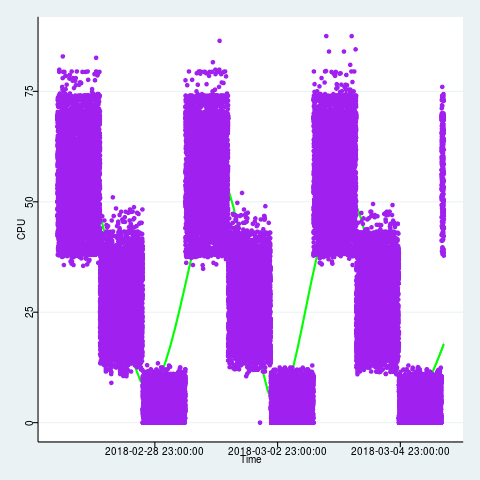

In [120]:
%%R
library(ggplot2)
library(scales)
library(ggthemes)
ggplot(data=data,aes(x=time, y=V3)) + 
  stat_smooth(colour="green") +
  geom_point(colour="purple",na.rm=TRUE) + 
  theme_stata()+
  ylab("CPU") + 
  xlab("Time") +
  (scale_x_datetime(labels=date_format("%Y-%m-%d %H:%M:%S")))
  
